In [7]:
## Load Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import pipeline, AutoTokenizer

In [8]:
# Target emotions we want to analyze
TARGET_EMOTIONS = [
    'fear', 'optimism', 'anxiety', 'nervousness', 'disappointment',
    'sadness', 'excitement', 'joy', 'relief', 'hope', 'worry', 'dread', 'confidence'
]

In [9]:
# Load tokenizer for length checking
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
max_length = 512  # Maximum length the model can handle

In [10]:
# Set up the emotion analysis pipeline using a pre-trained model
emotion_analyzer = pipeline(
    "text-classification",
    model="joeddav/distilbert-base-uncased-go-emotions-student",
    return_all_scores=True,
    truncation=True,  # Enable truncation
    max_length=max_length  # Set maximum length
)


Device set to use cuda:0


In [11]:
## Load Review Data
df_emotion = pd.read_csv("/content/combined_review_data.csv")

In [12]:
result_df = df_emotion.copy()


In [13]:
# Add columns for each emotion
for emotion in TARGET_EMOTIONS:
    result_df[emotion] = 0.0

In [14]:
review_column = 'review'  # Your review column name
batch_size = 32
reviews = result_df[review_column].fillna("").tolist()
total_batches = (len(reviews) + batch_size - 1) // batch_size


In [15]:
print(f"Processing {len(reviews)} reviews in {total_batches} batches...")

Processing 126725 reviews in 3961 batches...


In [16]:
# Check review lengths and identify long reviews
long_reviews = 0
for review in reviews:
    tokens = tokenizer.encode(review, add_special_tokens=True)
    if len(tokens) > max_length:
        long_reviews += 1

if long_reviews > 0:
    print(f"Found {long_reviews} reviews longer than the maximum token length of {max_length}.")
    print("These reviews will be automatically truncated during processing.")

for i in tqdm(range(0, len(reviews), batch_size)):
    batch = reviews[i:i+batch_size]

    # Skip empty reviews and handle long reviews
    processed_batch = []
    for review in batch:
        if not review.strip():
            processed_batch.append("neutral")
        else:
            # The pipeline's truncation will handle overly long reviews
            processed_batch.append(review)

    # Get emotion scores for the batch
    try:
        emotions_batch = emotion_analyzer(processed_batch)

        # Process each review in the batch
        for j, emotions in enumerate(emotions_batch):
            idx = i + j
            if idx >= len(result_df):
                break

            # Extract scores for target emotions
            for emotion_data in emotions:
                emotion = emotion_data['label'].replace('emotion_', '')
                score = emotion_data['score']

                if emotion in TARGET_EMOTIONS:
                    result_df.at[idx, emotion] = score
    except Exception as e:
        print(f"Error processing batch {i//batch_size + 1}/{total_batches}: {e}")
        print(f"Skipping batch and continuing...")
        continue

Token indices sequence length is longer than the specified maximum sequence length for this model (518 > 512). Running this sequence through the model will result in indexing errors


Found 397 reviews longer than the maximum token length of 512.
These reviews will be automatically truncated during processing.


  0%|          | 0/3961 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
 # Add dominant emotion column
print("Identifying dominant emotions for each review...")
for idx, row in result_df.iterrows():
    max_score = 0
    dominant_emotion = 'neutral'

    for emotion in TARGET_EMOTIONS:
        score = row.get(emotion, 0)
        if score > max_score:
            max_score = score
            dominant_emotion = emotion

    result_df.at[idx, 'dominant_emotion'] = dominant_emotion

In [ ]:
result_df


## Average emotion scores across all reviews

In [19]:
# Calculate average emotion scores
emotion_cols = [emotion for emotion in TARGET_EMOTIONS]  # No 'emotion_' prefix
avg_emotions = result_df[emotion_cols].mean().sort_values(ascending=False)

print("\nAverage emotion scores across all reviews:")
print(avg_emotions)



Average emotion scores across all reviews:
disappointment    0.072520
excitement        0.041951
relief            0.038141
joy               0.030576
optimism          0.025321
sadness           0.020504
nervousness       0.018222
fear              0.012035
anxiety           0.000000
hope              0.000000
worry             0.000000
dread             0.000000
confidence        0.000000
dtype: float64


In [20]:
avg_emotions = avg_emotions[avg_emotions > 0]

## Average Emotion Scores Across Reviews

<ipython-input-21-6af617f2d56a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_emotions.index, y=avg_emotions.values,palette='Set2')


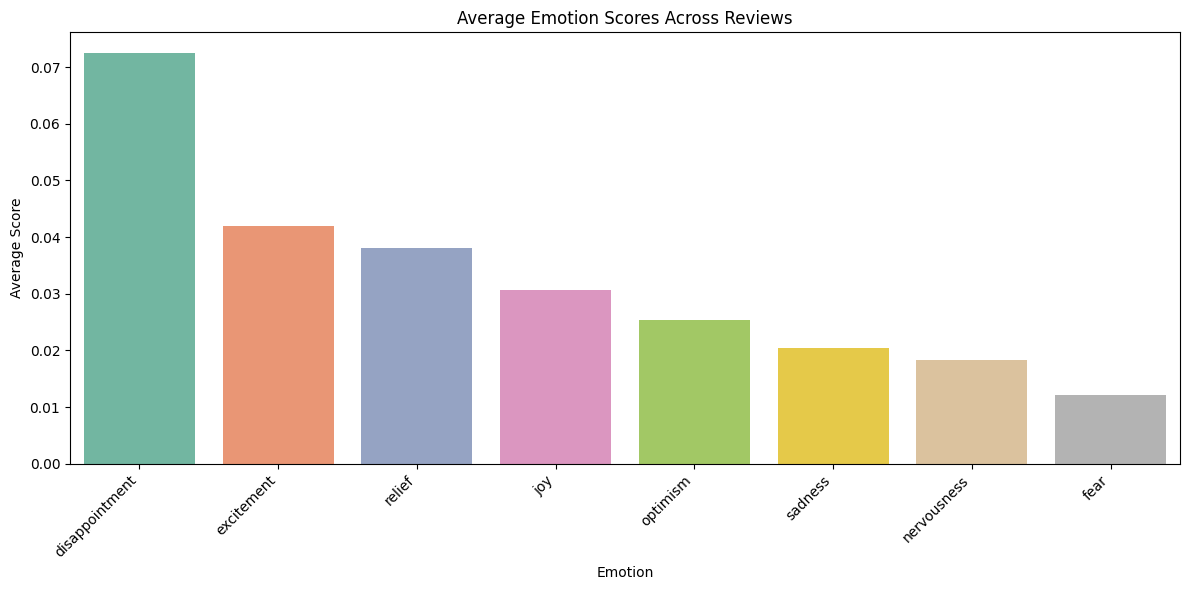

In [ ]:
#| echo: true
#Bar plot for average emotion scores across reviews
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_emotions.index, y=avg_emotions.values,palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Average Emotion Scores Across Reviews')
plt.xlabel('Emotion')  # <-- added x-axis label here
plt.ylabel('Average Score')
plt.tight_layout()
plt.show()


Disappointment is the most prominent emotion, indicating a generally unsatisfactory customer experience.
While positive emotions like excitement, relief, and joy appear next, their scores lag behind, showing mixed but leaning-negative sentiment.

## Emotion Scores by App Rating


Analyzing emotions by app rating...


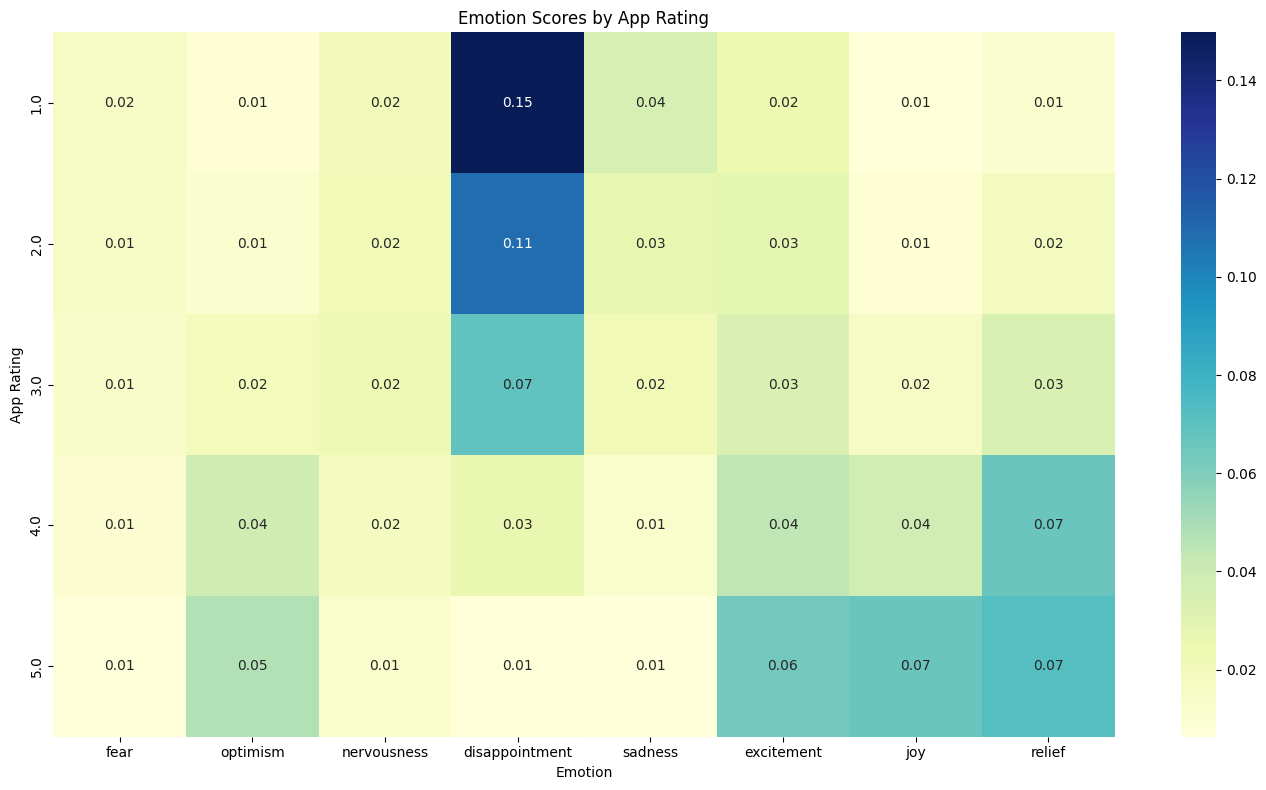

In [ ]:
#| echo: true
# Analyze emotions by app rating (if app_rating column exists)
if 'app_rating' in result_df.columns:
    print("\nAnalyzing emotions by app rating...")

    # Step 1: Group by rating and calculate average emotion scores
    emotions_by_rating = result_df.groupby('app_rating')[emotion_cols].mean()

    # Step 2: Remove columns where all values are zero
    emotions_by_rating = emotions_by_rating.loc[:, (emotions_by_rating != 0).any(axis=0)]

    # Plot heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(emotions_by_rating, cmap='YlGnBu', annot=True, fmt='.2f')
    plt.title('Emotion Scores by App Rating')
    plt.xlabel('Emotion')
    plt.ylabel('App Rating')
    plt.tight_layout()
    plt.show()


The heatmap clearly shows that disappointment is strongly associated with low ratings (1–2 stars),
 while positive emotions like excitement, joy, and relief become more prominent in higher-rated reviews
   (4–5 stars). This trend highlights that emotional tone closely mirrors customer satisfaction levels,
     with disappointment being a key indicator of negative app experiences.

In [23]:
# Count and visualize dominant emotions
emotion_counts = result_df['dominant_emotion'].value_counts()
print("\nDominant emotion counts:")
print(emotion_counts)



Dominant emotion counts:
dominant_emotion
disappointment    58007
excitement        24286
relief            24275
joy               13105
optimism           2951
nervousness        2813
sadness             982
fear                306
Name: count, dtype: int64


## Dominant Emotions in Reviews

<ipython-input-24-8c7cce383c0d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='Set2')


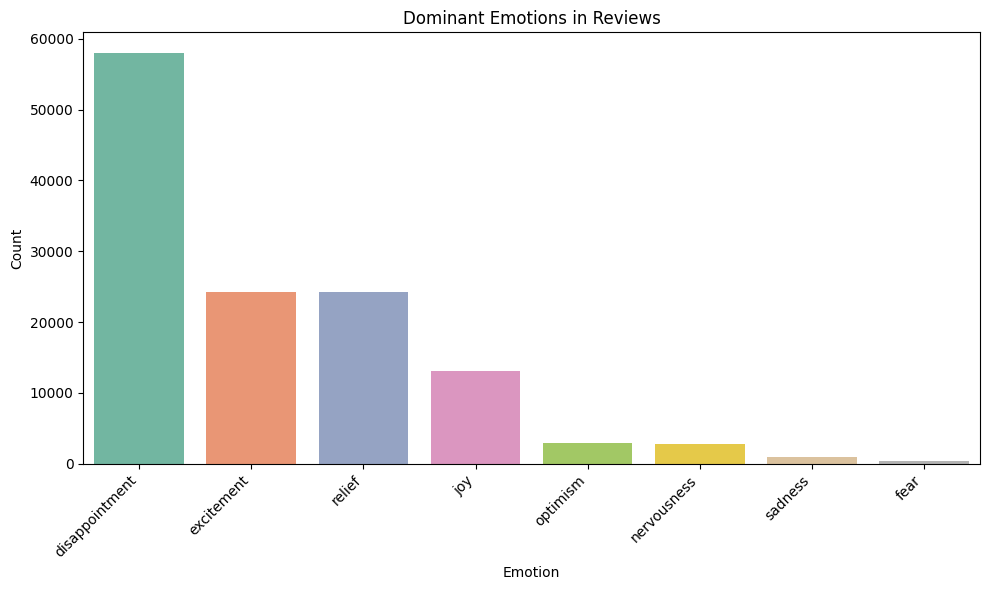

In [ ]:
#| echo: true
#Dominant emotions in reviews bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='Set2')
plt.title('Dominant Emotions in Reviews')
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Disappointment is the dominant emotion in the majority of reviews, significantly outpacing all other
 emotional categories. Excitement and relief also appear frequently, suggesting some positive
   experiences. However, the imbalance highlights that customer dissatisfaction is a core theme 
   across feedback platforms

## Emotion Scores by App


Analyzing emotions by app name...


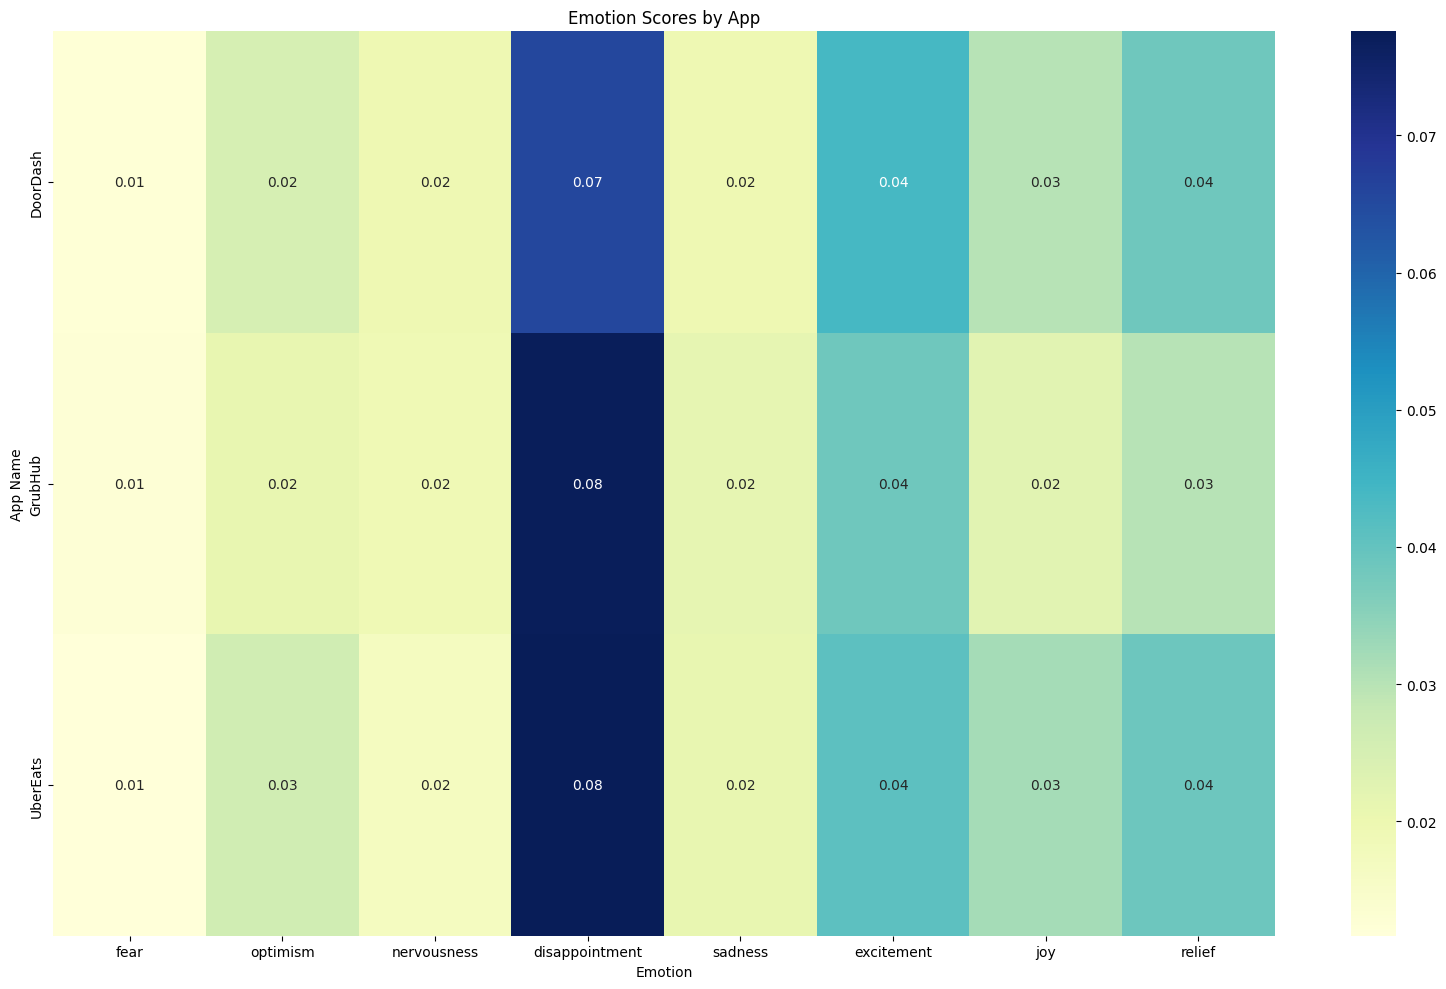

In [ ]:
#| echo: true
# Analyze emotions by app name (if app_name column exists)
if 'app_name' in result_df.columns and len(result_df['app_name'].unique()) > 1:
    print("\nAnalyzing emotions by app name...")

    # Step 1: Group by app name and calculate average emotion scores
    app_emotions = result_df.groupby('app_name')[emotion_cols].mean()

    # Step 2: Remove columns where all values are zero
    app_emotions = app_emotions.loc[:, (app_emotions != 0).any(axis=0)]

    # Step 3: Plot heatmap
    plt.figure(figsize=(16, 10))
    sns.heatmap(app_emotions, cmap='YlGnBu', annot=True, fmt='.2f')
    plt.title('Emotion Scores by App')
    plt.xlabel('Emotion')
    plt.ylabel('App Name')
    plt.tight_layout()
    plt.show()



Disappointment is the leading emotion across DoorDash, Grubhub, and UberEats, with Grubhub and UberEats displaying slightly
 higher levels. Positive emotions like excitement, joy, and relief appear consistently but are less dominant. This indicates a 
 shared challenge across platforms in fully meeting customer expectations.

## Most Dynamic Emotions Over Time


Analyzing emotions over time...


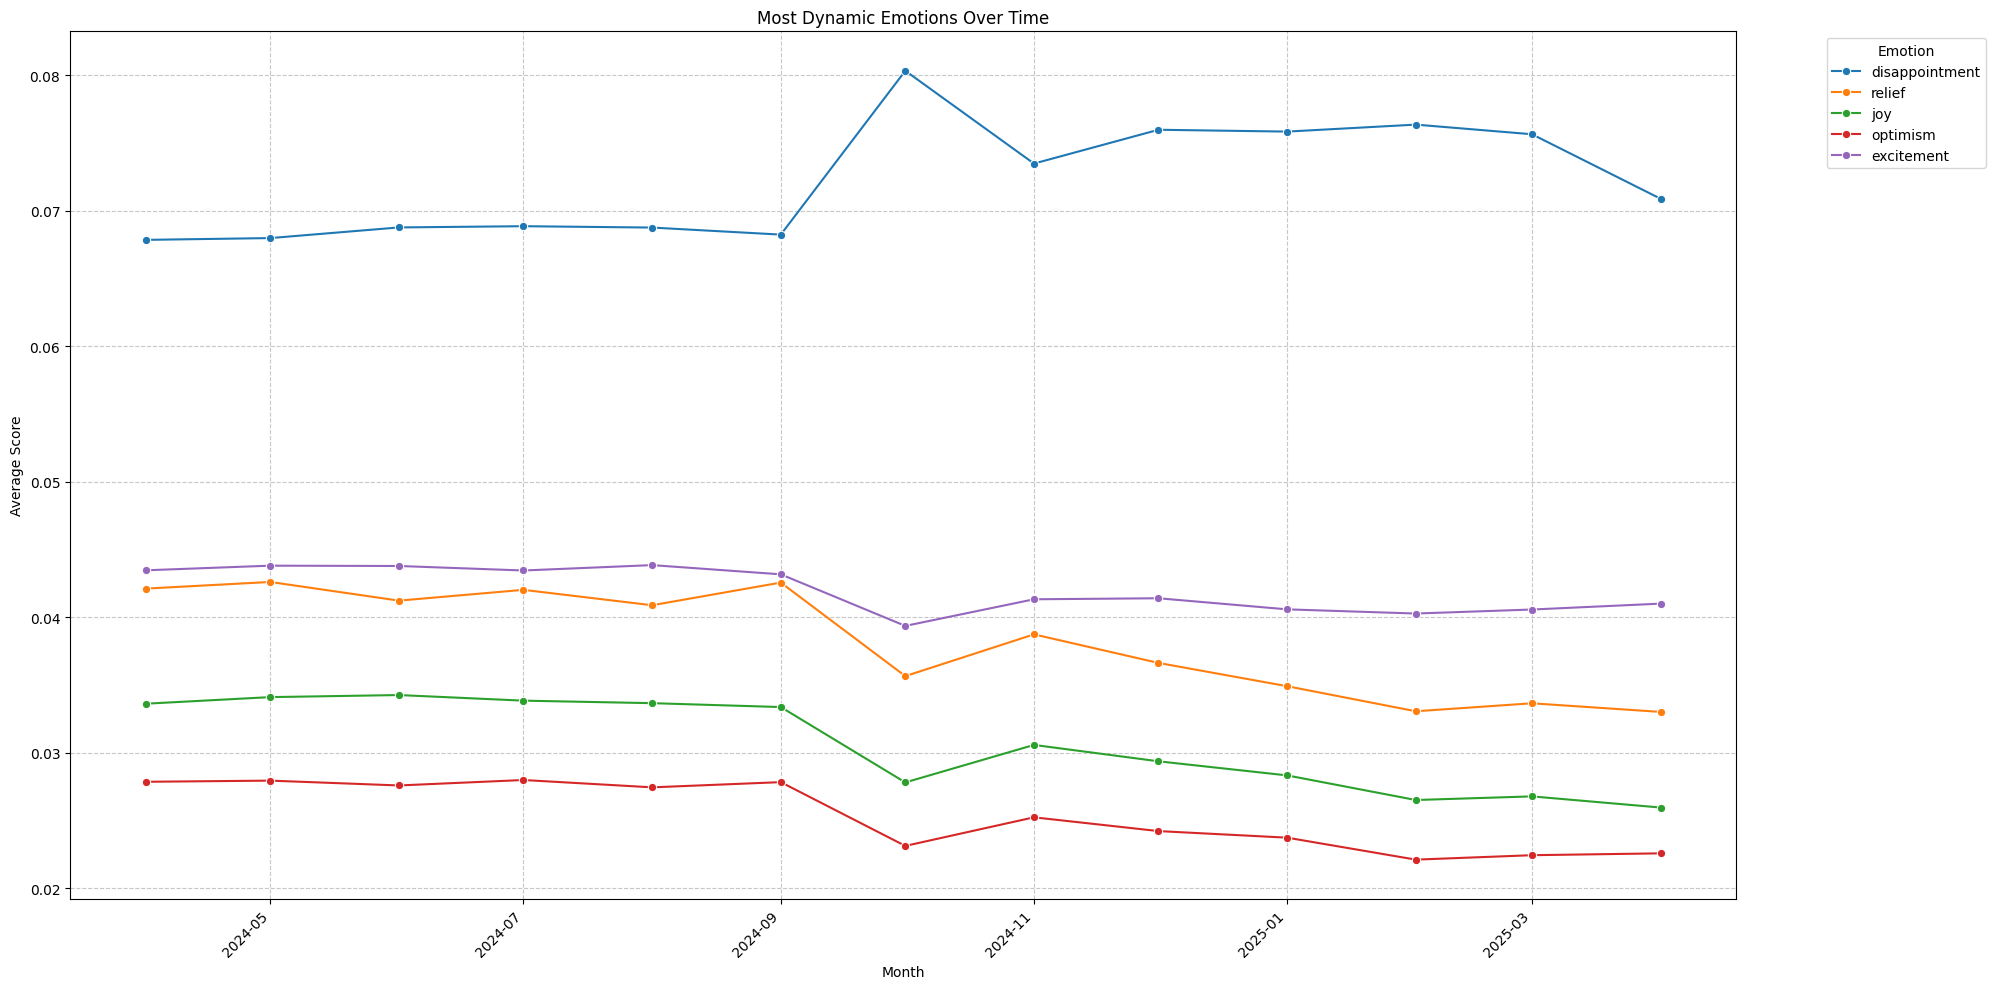

In [ ]:
#| echo: true
# Analyze emotions over time if datetime column exists
if 'review_datetime' in result_df.columns:
    try:
        print("\nAnalyzing emotions over time...")
        # Convert to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(result_df['review_datetime']):
            result_df['review_datetime'] = pd.to_datetime(result_df['review_datetime'], errors='coerce')

        # Create a month column for grouping
        result_df['month'] = result_df['review_datetime'].dt.to_period('M')

        # Group by month and calculate average emotion scores
        monthly_emotions = result_df.groupby('month')[emotion_cols].mean()

        # Remove emotions with all zero values
        monthly_emotions = monthly_emotions.loc[:, (monthly_emotions != 0).any(axis=0)]

        # Convert 'month' to timestamp
        monthly_emotions.index = monthly_emotions.index.to_timestamp()

        # ✨ NEW: Select only emotions with highest variability (standard deviation)
        emotion_std = monthly_emotions.std().sort_values(ascending=False)
        top_emotions = emotion_std.head(5).index  # Pick top 5 emotions with most variation

        # Filter to only those emotions
        monthly_emotions = monthly_emotions[top_emotions]

        # Reshape data for seaborn
        monthly_emotions_long = monthly_emotions.reset_index().melt(id_vars='month', var_name='Emotion', value_name='Average Score')

        # Plot using Seaborn
        plt.figure(figsize=(20, 10))
        sns.lineplot(data=monthly_emotions_long, x='month', y='Average Score', hue='Emotion', marker='o')

        plt.title('Most Dynamic Emotions Over Time')
        plt.ylabel('Average Score')
        plt.xlabel('Month')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not create emotions over time chart: {e}")


Disappointment consistently remains the dominant emotion over time, peaking sharply around September 2024. 
Positive emotions such as relief, joy, and optimism decline steadily after mid-2024, suggesting a gradual deterioration in 
user satisfaction. Excitement shows relatively stable trends throughout the period.

## Heatmap for Emotion Scores by Data Source


Analyzing emotions by data source...


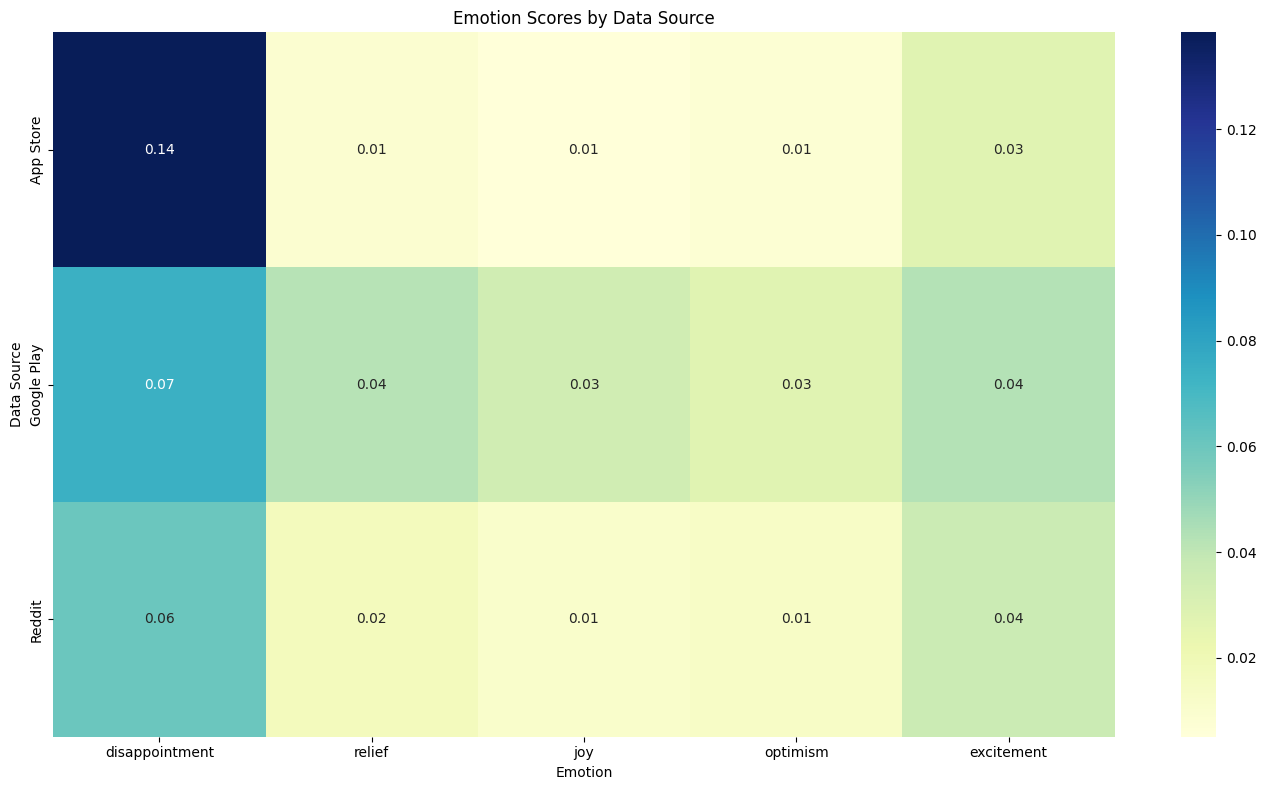

In [ ]:
#| echo: true
# Analyze emotions by data source if 'data_source' column exists
if 'data_source' in result_df.columns:
    try:
        print("\nAnalyzing emotions by data source...")

        # Group by data_source and calculate average emotion scores
        source_emotions = result_df.groupby('data_source')[emotion_cols].mean()

        # Remove emotions with all zero values
        source_emotions = source_emotions.loc[:, (source_emotions != 0).any(axis=0)]

        # ✨ Select most dynamic emotions (optional: top 5 by std deviation)
        emotion_std = source_emotions.std().sort_values(ascending=False)
        top_emotions = emotion_std.head(5).index

        # Filter only top emotions
        source_emotions = source_emotions[top_emotions]

        # Plot heatmap
        plt.figure(figsize=(14, 8))
        sns.heatmap(source_emotions, cmap='YlGnBu', annot=True, fmt='.2f')

        plt.title('Emotion Scores by Data Source')
        plt.xlabel('Emotion')
        plt.ylabel('Data Source')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not create emotion comparison heatmap: {e}")

Disappointment is most pronounced in App Store reviews, indicating a higher level of 
dissatisfaction compared to Google Play and Reddit. Google Play reviews show a more balanced 
emotional spread, while Reddit displays lower overall emotional intensity. This highlights
 that App Store feedback tends to be more emotionally charged and negative.

## Bar Plot for Emotion Scores by App and Data Source


Analyzing emotions by App and Data Source (Bar Plot)...


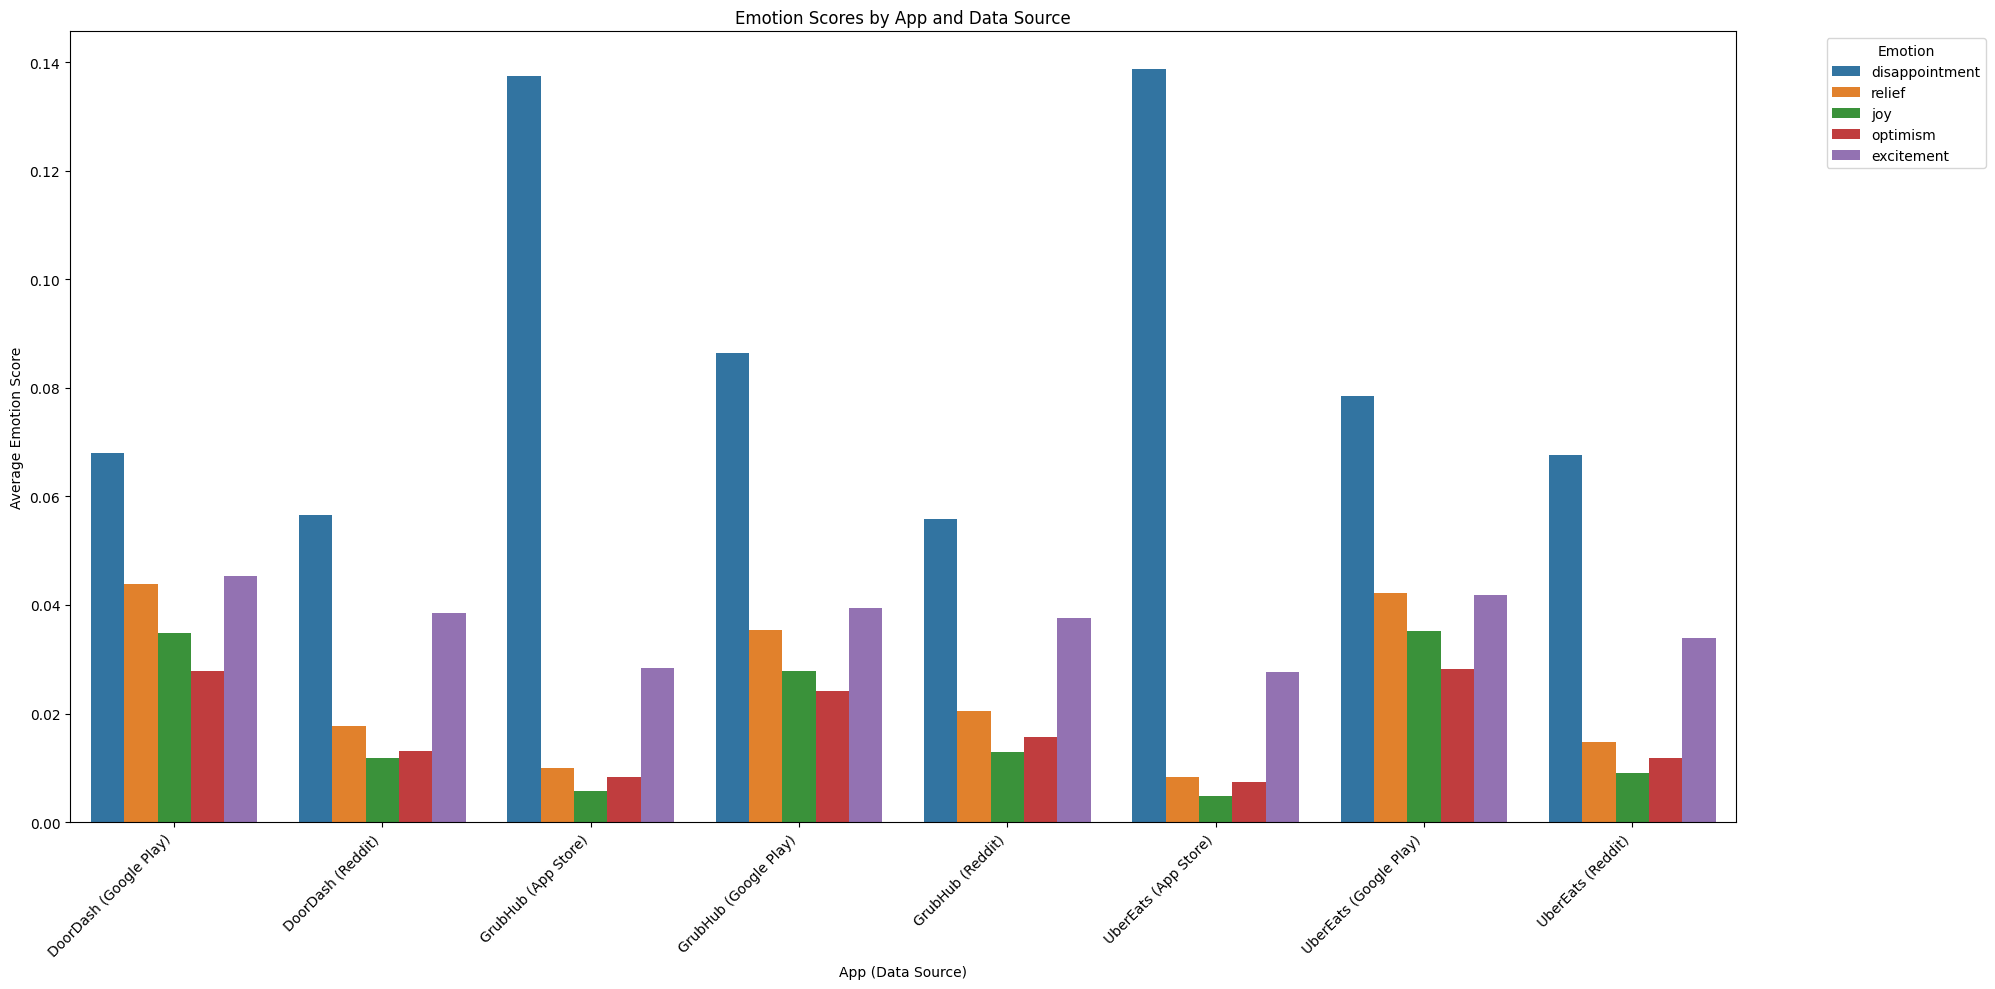

In [ ]:
#| echo: true
# Analyze emotions by app and data source
if 'app_name' in result_df.columns and 'data_source' in result_df.columns:
    try:
        print("\nAnalyzing emotions by App and Data Source (Bar Plot)...")

        # Group by both app_name and data_source
        app_source_emotions = result_df.groupby(['app_name', 'data_source'])[emotion_cols].mean()

        # Remove emotions with all zero values
        app_source_emotions = app_source_emotions.loc[:, (app_source_emotions != 0).any(axis=0)]

        # ✨ Select top varying emotions (optional: top 5)
        emotion_std = app_source_emotions.std().sort_values(ascending=False)
        top_emotions = emotion_std.head(5).index

        # Filter only top emotions
        app_source_emotions = app_source_emotions[top_emotions]

        # Reset index to make it plottable
        app_source_emotions = app_source_emotions.reset_index()

        # Create one combined label for app and data source
        app_source_emotions['App_Source'] = app_source_emotions['app_name'] + ' (' + app_source_emotions['data_source'] + ')'

        # Melt the dataframe for seaborn plotting
        app_source_long = app_source_emotions.melt(id_vars='App_Source', value_vars=top_emotions,
                                                   var_name='Emotion', value_name='Average Score')

        # Plot
        plt.figure(figsize=(20, 10))
        sns.barplot(data=app_source_long, x='App_Source', y='Average Score', hue='Emotion')

        plt.title('Emotion Scores by App and Data Source')
        plt.xlabel('App (Data Source)')
        plt.ylabel('Average Emotion Score')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not create combined bar plot: {e}")

## Heatmap for Emotion Scores Across Apps and Data Sources


Analyzing emotions by App and Data Source (Simple Heatmap)...


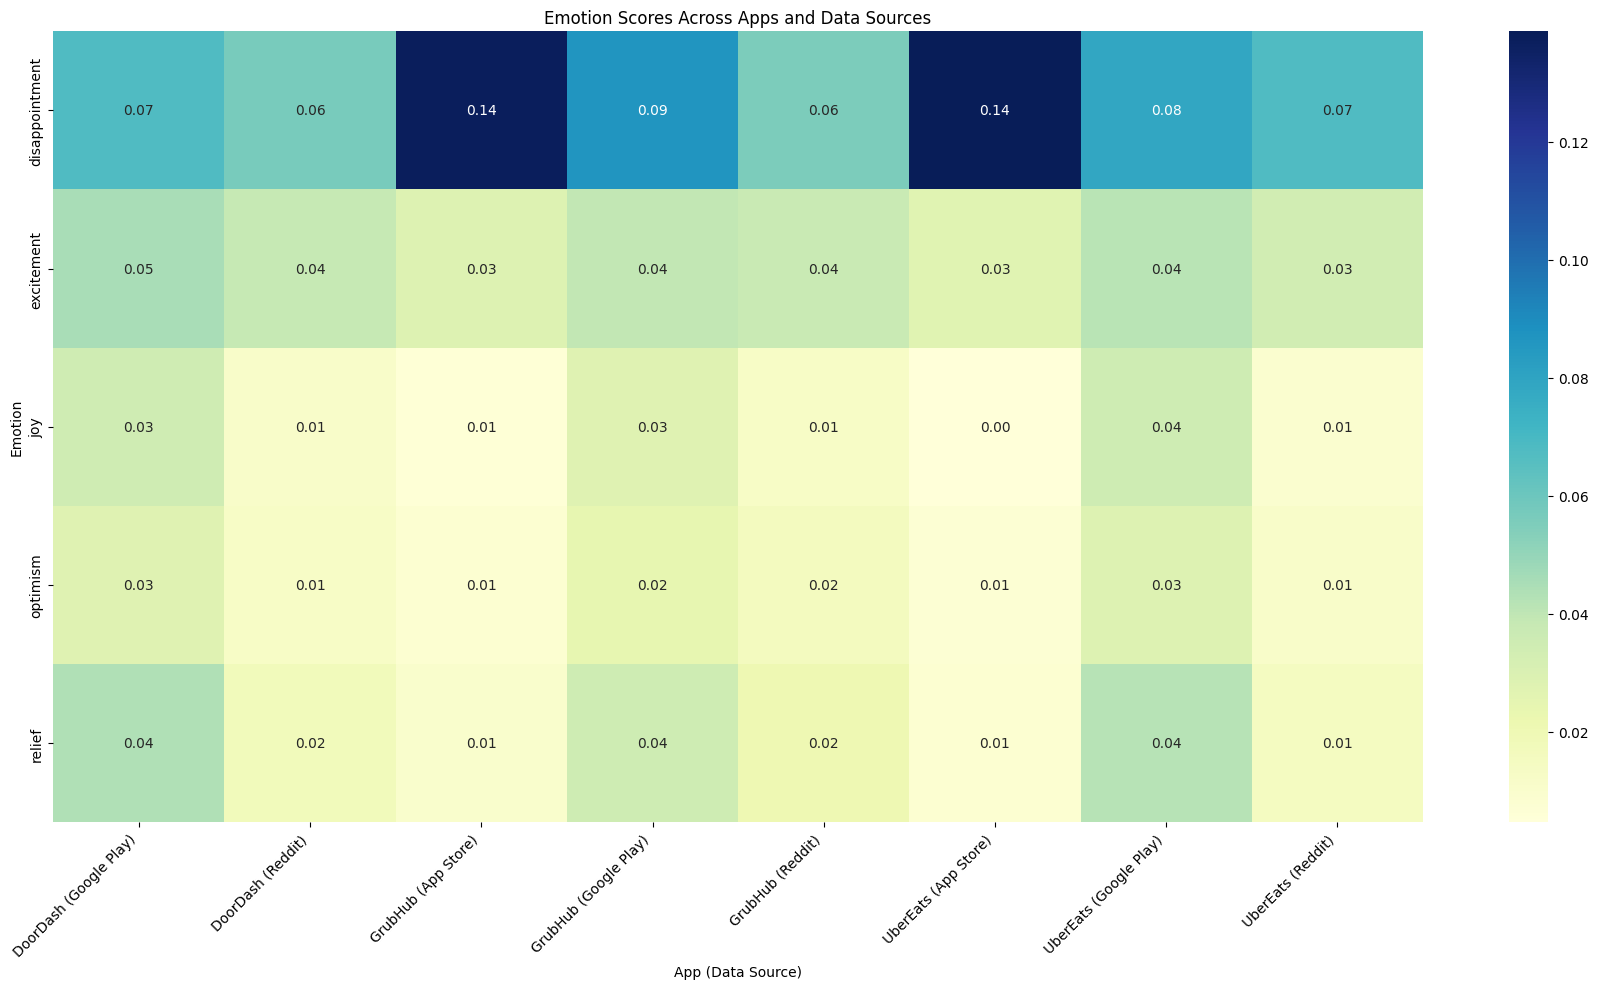

In [ ]:
#| echo: true

# Analyze emotions by app and data source -  Heatmap
if 'app_name' in result_df.columns and 'data_source' in result_df.columns:
    try:
        print("\nAnalyzing emotions by App and Data Source (Simple Heatmap)...")

        # Group by both app_name and data_source
        app_source_emotions = result_df.groupby(['app_name', 'data_source'])[emotion_cols].mean()

        # Remove emotions with all zero values
        app_source_emotions = app_source_emotions.loc[:, (app_source_emotions != 0).any(axis=0)]

        # ✨ Select top varying emotions (optional: top 5)
        emotion_std = app_source_emotions.std().sort_values(ascending=False)
        top_emotions = emotion_std.head(5).index

        # Filter only top emotions
        app_source_emotions = app_source_emotions[top_emotions]

        # Create one combined label for app and data source
        app_source_emotions = app_source_emotions.reset_index()
        app_source_emotions['App_Source'] = app_source_emotions['app_name'] + ' (' + app_source_emotions['data_source'] + ')'

        # Now pivot the table: Emotion (rows) × App_Source (columns)
        pivot_table = app_source_emotions.melt(id_vars=['App_Source'], value_vars=top_emotions,
                                               var_name='Emotion', value_name='Average Score')
        pivot_table = pivot_table.pivot(index='Emotion', columns='App_Source', values='Average Score')

        # Plot heatmap
        plt.figure(figsize=(18, 10))
        sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='.2f')

        plt.title('Emotion Scores Across Apps and Data Sources')
        plt.xlabel('App (Data Source)')
        plt.ylabel('Emotion')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not create simple heatmap: {e}")


Disappointment clearly dominates customer emotions across all apps and platforms,
 especially for Grubhub and UberEats on the App Store. Google Play reviews display
more emotional diversity, while Reddit feedback remains relatively muted.
 This reinforces that App Store reviews tend to reflect stronger dissatisfaction

In [31]:
# Save results to CSV
result_df.to_csv('reviews_with_emotions.csv', index=False)